# Исследование рынка общественного питания города Москвы

## Цели и задачи исследования

**Заказчики**:\
инвесторы из фонда «My Money».


**Цель заказчиков**:\
открыть заведение общественного питания в Москве.


 **Необходимо определить** в результате исследования:
- место расположения,
- тип заведения (кафе, ресторан, пиццерия, бар или другое),
- предпочтительную ценовую категорию.

**Задача**:\
провести исследование рынка общественного питания Москвы, найти интересные особенности рынка и визуализировать результаты.

**Описание данных**

Имеется датасет с заведениями общественного питания Москвы, составленный на основе данных сервисов Яндекс Карты и Яндекс Бизнес на лето 2022 года.\
Информация, размещённая в сервисе Яндекс Бизнес, могла быть добавлена пользователями или найдена в общедоступных источниках.

 <div class="alert alert-info"> <b> </b> </div>

## Выгрузка и предобработка данных

### Выгрузка данных

In [9]:
import pandas as pd
import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
import folium
import numpy as np
import json
import geopandas as gpd
import plotly

# Отображение вывода в той же ячейке
#%matplotlib inline

In [10]:
try:
    df = pd.read_csv ('/datasets/moscow_places.csv')
except:
    df = pd.read_csv ('moscow_places.csv')
df.sample(3)
#df.head()

,name,category,address,district,hours,lat,lng,rating,price,avg_bill,middle_avg_bill,middle_coffee_cup,chain,seats
3827,Теремок,ресторан,"Москва, улица Новый Арбат, 17",Центральный административный округ,"ежедневно, 10:00–22:00",55.752138,37.590232,4.3,низкие,Средний счёт:250 ₽,250.0,NaN,1,100.0
6813,Татнефть кафе,ресторан,"Москва, улица Островитянова, вл1Б",Юго-Западный административный округ,"ежедневно, 08:00–00:00",55.647539,37.486086,3.7,NaN,NaN,NaN,NaN,1,NaN
171,One Price Coffee,кофейня,"Москва, Дмитровское шоссе, 163А, корп. 1",Северо-Восточный административный округ,"ежедневно, 10:00–22:00",55.909838,37.541526,4.0,NaN,NaN,NaN,NaN,1,350.0


In [11]:
#Выводим информацию о таблице, смотрим тип данных и их полноту
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8406 entries, 0 to 8405
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               8406 non-null   object 
 1   category           8406 non-null   object 
 2   address            8406 non-null   object 
 3   district           8406 non-null   object 
 4   hours              7870 non-null   object 
 5   lat                8406 non-null   float64
 6   lng                8406 non-null   float64
 7   rating             8406 non-null   float64
 8   price              3315 non-null   object 
 9   avg_bill           3816 non-null   object 
 10  middle_avg_bill    3149 non-null   float64
 11  middle_coffee_cup  535 non-null    float64
 12  chain              8406 non-null   int64  
 13  seats              4795 non-null   float64
dtypes: float64(6), int64(1), object(7)
memory usage: 919.5+ KB


В датасете содержится 8406 строк. Есть ли дублирующие записи, пока не известно.\
\
Есть пропуски в данных, касающихся экономических харпактеристик заведения.\
Кол-во посадочных мест (seats) - информация отсутствует у почти 40 процентов записей.\
Ценовые характеристики имеют менее половины заведений.

Типы данных в столбцах соответствуют их содержанию. 

### Предобработка данных

#### Проверяем дубликаты в данных

Полными дубликатами можно считать одновременное совпадение названия и координат. При этом несовпадения в других полях не принципиальны.

In [16]:
# Выводим новую переменную для удобства и безопасности и дальше работаем с ней
df_s = df
# приводим столбец 'name' к нижнему регистру
df_s['name'] = df_s['name'].str.lower()
duplicates = df_s[df_s.duplicated(subset=['name', 'lat', 'lng'], keep=False)]
duplicates

,name,category,address,district,hours,lat,lng,rating,price,avg_bill,middle_avg_bill,middle_coffee_cup,chain,seats
1430,more poke,ресторан,"Москва, Волоколамское шоссе, 11, стр. 2",Северный административный округ,"ежедневно, 09:00–21:00",55.806307,37.497566,4.2,NaN,NaN,NaN,NaN,0,188.0
1511,more poke,ресторан,"Москва, Волоколамское шоссе, 11, стр. 2",Северный административный округ,"пн-чт 09:00–18:00; пт,сб 09:00–21:00; вс 09:00...",55.806307,37.497566,4.2,NaN,NaN,NaN,NaN,1,188.0


Удалим конкретную строку-дубликат по её номеру. Оставим ту, в которой есть более подробное расписание времени работы.

In [18]:
df_s = df_s.drop(index = [1430]).reset_index(drop=True)

# проверяем (количество строк должно уменьшиться на одну. Так и есть.)
df_s.shape

(8405, 14)

#### Обработка пропусков

In [20]:
# Смотрим, где пропуски
df_s.isna().sum()

name                    0
category                0
address                 0
district                0
hours                 536
lat                     0
lng                     0
rating                  0
price                5090
avg_bill             4589
middle_avg_bill      5256
middle_coffee_cup    7870
chain                   0
seats                3611
dtype: int64

Пропуски встречаются в столбцах:
- hours (Время работы), 
- столбцах с экономическими данными,
- в столбце seats (Количество мест).

Вводим категорию **'нет данных'** для столбцов: 
- hours, 
- price
- avg_bill

У столбцов **'middle_avg_bill',  'middle_coffee_cup',  'seats'**  оставим пропуски без изменений\
(для расчётов целесообразнее оставить NaN и тем самым не менять числовой формат данных).

In [22]:
# Вводим категорию 'нет данных' для некоторых столбцов:
columns_fillna = ['hours', 'price', 'avg_bill']
df_s[columns_fillna] = df_s[columns_fillna].fillna('нет данных')

# проверяем
df_s.isna().sum()

name                    0
category                0
address                 0
district                0
hours                   0
lat                     0
lng                     0
rating                  0
price                   0
avg_bill                0
middle_avg_bill      5256
middle_coffee_cup    7870
chain                   0
seats                3611
dtype: int64

#### Меняем значения 1 и 0 в столбце chain

In [24]:
df_s['chain']=df_s['chain'].replace([0,1],['единичное','сетевое'])
#df_s

#### Сокращаем одно из названий

In [26]:
df_s['name'] = df_s['name'].str.replace('кулинарная лавка братьев караваевых', 'лавка караваевых')
#df_s

#### Сокращаем представление андминистративных округов до АО

В сокращённом виде наименования округов выглядят значительно читаемее ('административный округ' = 'АО').

In [29]:
# Сокращаем представление андминистративных округов в столбце district
df_s['district'] = df_s['district'].str.replace('административный округ', 'АО')
#df_s

In [30]:
# Сокращаем представление андминистративных округов в geojson-файле
# для согласования названий

# Загружаем GeoJSON файл в GeoDataFrame
geojson = gpd.read_file('admin_level_geomap.geojson')

# Заменяем 'административный округ' на 'АО' в столбце 'name'
geojson['name'] = geojson['name'].str.replace('административный округ', 'АО')

# Сохраняем изменённый GeoDataFrame обратно в GeoJSON-файл и дальше пользуемся им
geojson.to_file('modified_admin_level_geomap.geojson', driver='GeoJSON', encoding='utf-8')
geojson.head(3)

,ref,name,name:be,name:de,name:en,name:ru,website,boundary,wikipedia,omkte:code,addr:region,admin_level,addr:country,contact:website,geometry
0,ВАО,Восточный АО,Усходняя адміністрацыйная акруга,Östlicher Verwaltungsbezirk,Eastern Administrative Okrug,Восточный административный округ,http://www.vao.mos.ru,administrative,ru:Восточный административный округ,None,Москва,5,RU,None,"MULTIPOLYGON (((37.87567 55.82534, 37.87600 55..."
1,САО,Северный АО,Паўночная адміністрацыйная акруга,Nördlicher Verwaltungsbezirk,Northern Administrative Okrug,None,http://www.sao.mos.ru/,administrative,ru:Северный административный округ,None,Москва,5,RU,None,"MULTIPOLYGON (((37.42178 55.95024, 37.42071 55..."
2,ЮЗАО,Юго-Западный АО,Паўднёва-заходняя адміністрацыйная акруга,Südwestlicher Verwaltungsbezirk,South-Western Administrative Okrug,Юго-Западный административный округ,http://www.uzao.mos.ru/,administrative,ru:Юго-Западный административный округ,None,Москва,5,RU,None,"MULTIPOLYGON (((37.61838 55.68450, 37.61700 55..."


In [31]:
# Смотрим, где после модификации находится ключ. До модификации он был  key_on='feature.name'
# После модификации файла key_on='feature.properties.name'
# Ключ нам понадобится при постороении карт

with open('modified_admin_level_geomap.geojson', 'r', encoding='utf-8') as f:
    geo_data = json.load(f)
#print(json.dumps(geo_data, indent=2))


#### Создаём столбец 'street' с названиями улиц и столбец 'is_24_7' с указанием круглосуточной работы

In [33]:
# Разбиваем строку по запятой и пробелу, затем берем второй элемент полученного списка
def ex_address(address):   
    street_name = address.split(', ')[1]
    return street_name

# Применяем функцию к столбцу 'address' и записываем результат в новый столбец
df_s['street'] = df_s['address'].apply(ex_address)
#df_s

In [34]:
# Создаём столбец 'is_24_7'
def categorize_hours(row):
    if 'ежедневно' in row and 'круглосуточно' in row:
        return '24/7 - ДА'
    else:
        return '24/7 - НЕТ'
df_s['is_24_7'] = df_s['hours'].apply(categorize_hours)   

# проверяем
display(df_s['is_24_7'].value_counts())
print(df_s['is_24_7'].dtypes)
df_s.head(3)
#df_s.info()

is_24_7
24/7 - НЕТ    7675
24/7 - ДА      730
Name: count, dtype: int64

object


,name,category,address,district,hours,lat,lng,rating,price,avg_bill,middle_avg_bill,middle_coffee_cup,chain,seats,street,is_24_7
0,wowфли,кафе,"Москва, улица Дыбенко, 7/1",Северный АО,"ежедневно, 10:00–22:00",55.878494,37.478860,5.0,нет данных,нет данных,NaN,NaN,единичное,NaN,улица Дыбенко,24/7 - НЕТ
1,четыре комнаты,ресторан,"Москва, улица Дыбенко, 36, корп. 1",Северный АО,"ежедневно, 10:00–22:00",55.875801,37.484479,4.5,выше среднего,Средний счёт:1500–1600 ₽,1550.0,NaN,единичное,4.0,улица Дыбенко,24/7 - НЕТ
2,хазри,кафе,"Москва, Клязьминская улица, 15",Северный АО,"пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...",55.889146,37.525901,4.6,средние,Средний счёт:от 1000 ₽,1000.0,NaN,единичное,45.0,Клязьминская улица,24/7 - НЕТ


#### Добавляем столбец distance - расстояние от центра города

In [36]:
# Координаты центра города
moscow_lat = 55.751244
moscow_lng = 37.618423

# Расчет расстояния от каждой точки до центра города
df_s['distance'] = np.sqrt((df_s['lat'] - moscow_lat)**2 + (df_s['lng'] - moscow_lng)**2)

Формула для вычисления расстояния между двумя точками использует данные широты и долготы и **выражается в градусах широты и долготы**.
>Это не расстояние в километрах, но так как этот показаиель понадобится нам для иллюстрации зависимости цены от расстояния, то расстояние выраженное таким образом вполне адекватно для данной цели.


#### Проверка и корректирговка числовых данных

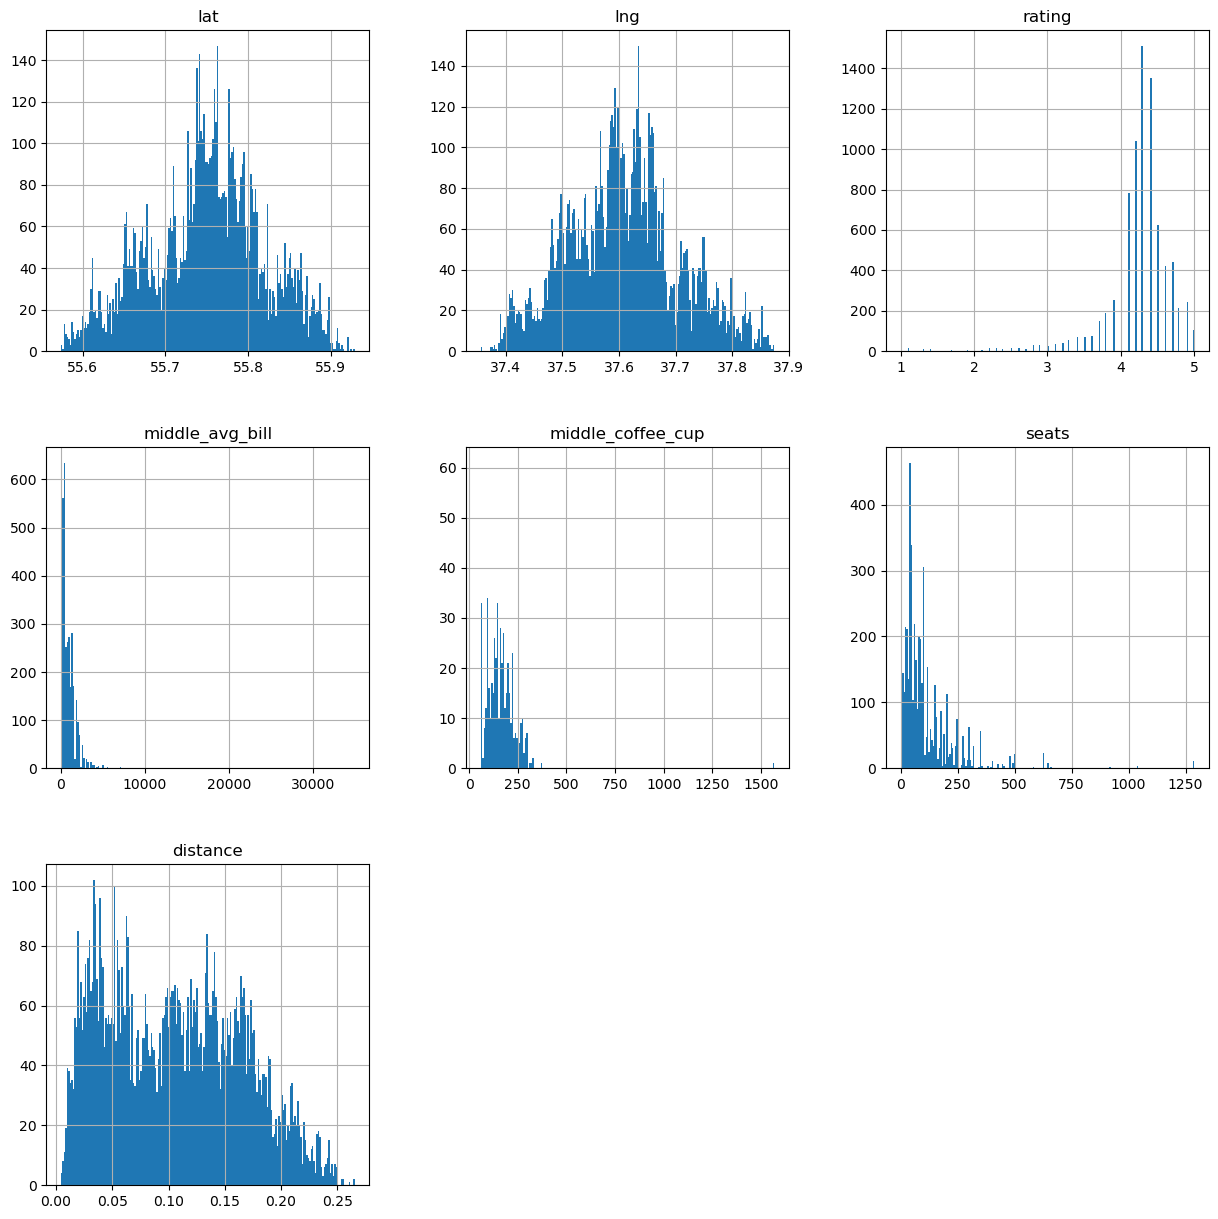

In [39]:
# Строим набор гистограмм для всех числовых столбцов таблицы на одном графике.
df_s.hist(bins=200,figsize=(15, 15));

Присцтствую следующие необычные значения:
- Средний чек 35000 руб.
- Цена чашки кофе в районе 1600 руб.
- Заведения с большим количеством - свыше 600 посадочных мест.

Первые два факта могут быть как ошибкой ввода данных, так и реальным заведением со стоимочтью чайки кофе 1800 и средним чеком 35000. Но такой сегмент находится за пределами интереса заказчиков исследования ("круто, нео массово"), поэтому удаляем эти значения как выбросы.

Большое количество мест указывает на то, что заведение может быть банкетным залом. Некоторые банкетные залы являются одновременно и действующими в обычном режиме ресторанами, но так как в задании речь имдёт о категории "кафе", то представляется цеолесообразным убрать из исследования заведения с количеством мест более 500. Это сугубо экспертное решение -граница 500 выбрана произвольно и может корректироваться в зависимости от пожелания заказчика. 

**Обрабатываем столбец middle_avg_bill**

In [42]:
# Посмотрим количество строк в срезе
elit = df_s[(df_s['middle_avg_bill']>10000)]
display (elit.shape)

# Делаем маску
mask_1 = (df_s['middle_avg_bill'] > 10000)

# Удаляем строки, соответствующие условию в маске
df_s = df_s.drop(df_s[mask_1].index).reset_index(drop=True)

# Проверяем, сколько строк осталось после обработки
elit_control = df_s[(df_s['middle_avg_bill']>10000)]
elit_control.shape

(2, 17)

(0, 17)

**Обрабатываем столбец middle_coffee_cup**

In [44]:
# Посмотрим количество строк в срезе
elit_2 = df_s[(df_s['middle_coffee_cup']>600)]
display (elit_2.shape)

# Делаем маску
mask_2 = (df_s['middle_coffee_cup'] > 600)

# Удаляем строки, соответствующие условию в маске
df_s = df_s.drop(df_s[mask_2].index).reset_index(drop=True)

# Проверяем, сколько строк осталось после обработки
elit_2_control = df_s[(df_s['middle_coffee_cup']>600)]
elit_2_control.shape

(1, 17)

(0, 17)

**Обрабатываем столбец seats**

In [46]:
# Посмотрим количество строк в срезе
big_hall = df_s[(df_s['seats']>500)]
display (big_hall.shape)

# Делаем маску
mask_3 = (df_s['seats'] > 500)

# Удаляем строки, соответствующие условию в маске
df_s = df_s.drop(df_s[mask_3].index).reset_index(drop=True)

# Проверяем, сколько строк осталось после обработки
big_hall_control = df_s[(df_s['seats']>500)]
big_hall_control.shape

(56, 17)

(0, 17)

**Проверяем, построив новые гистограммы**

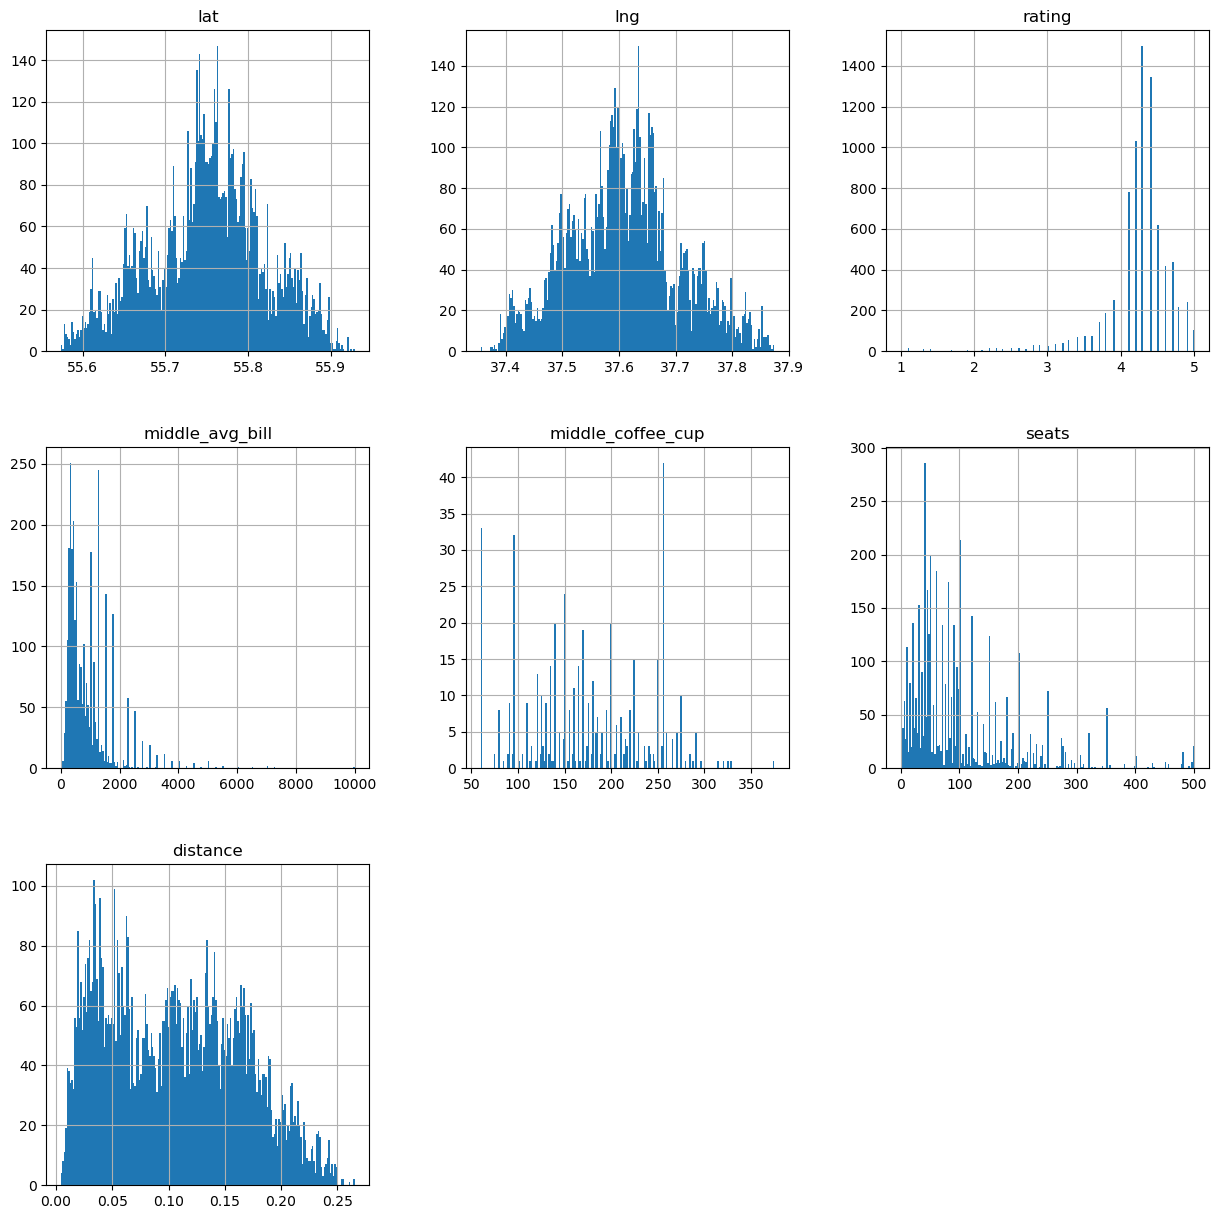

In [48]:
# Ввордим новую переменну. и работаем дальше с ней.
df_cl = df_s
# Строим набор гистограмм для всех числовых столбцов таблицы на одном графике.
df_cl.hist(bins=200,figsize=(15, 15));

На этом заканчиваем предобработку.

In [50]:
# Проверяем, сколько строк осталось в датасете 
df_cl.shape

(8346, 17)

В датасете было 8405 строк.\
После обработки осталось 8346.\
Мы удалили 59 строк. То есть всего **0,7%** данных. 

 <div class="alert alert-info"> <b> </b> </div>

## Анализ данных

### Категории заведений, представленые в данных
Количество объектов общественного питания по категориям\
Распределении заведений по категориям.

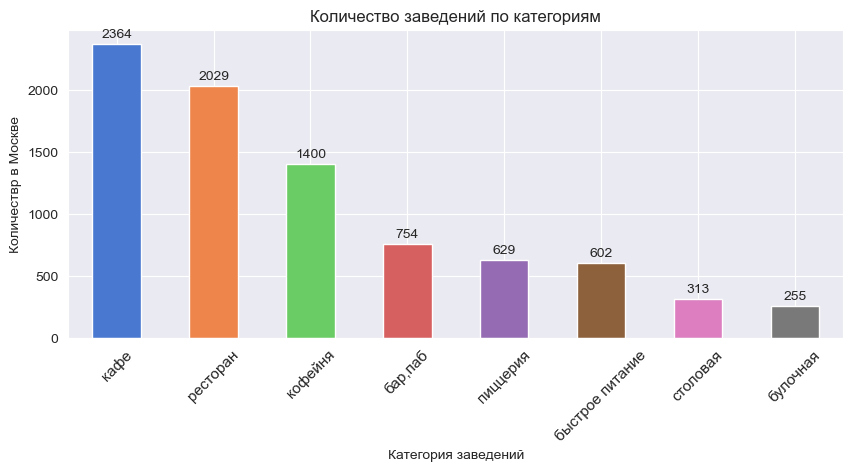

In [55]:
# выбираем тему оформления
sns.set_style('dark')
# группируем данные, считаем количество записей и сортируем
name_category = df_cl.groupby('category')['address'].count().sort_values(ascending=False)

# строим диаграмму
ax = name_category.plot(kind='bar', y='category',
                   figsize=(10,4),
                   xlabel='Категория заведений',
                   ylabel='Количествр в Москве',
                   color = sns.color_palette('muted'),
                   title='Количество заведений по категориям')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 7), textcoords='offset points')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=11)
plt.grid()
plt.show()


Мы видим, что большая часть заведений питания в Москве относятся к категориям "Кафе" и "Ресторан". Это трдиционно привычные названия. В сознании среднестатистического потребителя они имеют достаточно понятную дифференциацию: кафе - демократичнее и дешевле, ресторан пафоснее и дороже. На практике далеко не всегда так, но при выборе категории, ещё до проработки конкретного формата, эту особенность нужно учитывать.\
\
Третье место по распространённости занимает категория "Кофейня".

### Количество посадочных мест в точках общепита по категориям

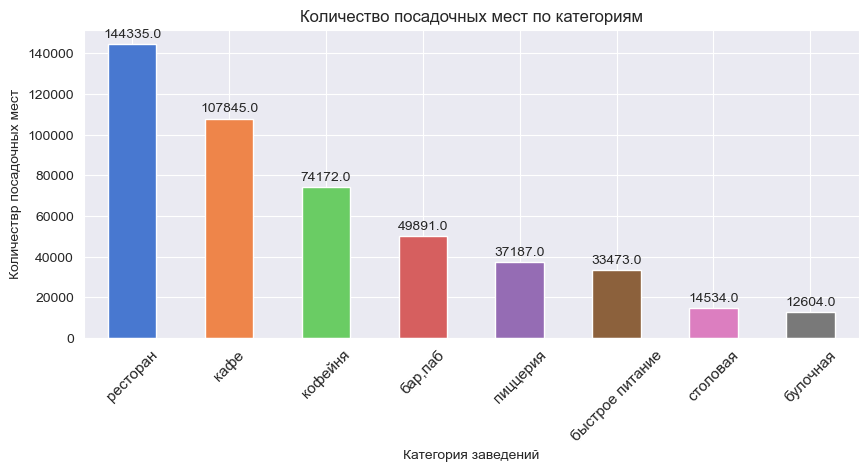

In [58]:
# группируем данные, считаем сумму значений и сортируем
seats_cat = df_cl.groupby('category')['seats'].sum().round(decimals=0).sort_values(ascending=False)
# строим диаграмму
ax = seats_cat.plot(kind='bar', y='category',
                   figsize=(10,4),
                   xlabel='Категория заведений',
                   ylabel='Количествр посадочных мест',
                   color = sns.color_palette('muted'),
                   title='Количество посадочных мест по категориям',)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 7), textcoords='offset points')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=11)
plt.grid()
plt.show()

Тройка лидеров осталась той же. Но по количеству мест рестораны, при их меньшем количестве в городе, обошли кафе.\
\
Это говорит о том, что в среднем ресторан имеет большее количество мест, чем кафе, а так как рассадка посетителей в ресторане более свободная, чем в кафе, можно сделать вывод, что зал среднего ресторана больше, зала среднего кафе. Следователоьно и общая занимаемая площадь - больше, что делает запуск этого формата более капиталоёмким уже на стадии подбора помещения.\
\
Остальные категории расределились по этой метрике в том же порядке, как и по общему количеству в городе.

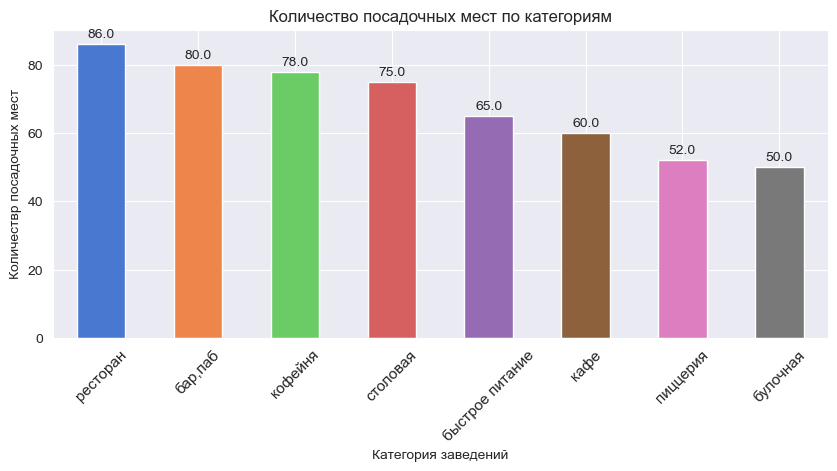

In [60]:
# группируем данные, считаем сумму значений и сортируем
seats_cat = df_cl.groupby('category')['seats'].median().round(decimals=0).sort_values(ascending=False)
# строим диаграмму
ax = seats_cat.plot(kind='bar', y='category',
                   figsize=(10,4),
                   xlabel='Категория заведений',
                   ylabel='Количествр посадочных мест',
                   color = sns.color_palette('muted'),
                   title='Количество посадочных мест по категориям',)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 7), textcoords='offset points')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=11)
plt.grid()
plt.show()

При оценки медианного значения картина меняется. Рестораны остаются лидерами, но второе место уже у Баров. Бары, как правило, меньше ресторанов, а близость их по этому показателю, вероятно, возникает из-за более плотной рассадки посетителей.

Близость Ресторанов, Баров, Кофеен и Столовых (неожиданно) можно объяснить тем, что в городе нет большого разброса по размеру площади помещений, пригоднух для открытия пищеой точки.

>Чем можно объяснить неожиданно большое значения показателя для Булочных - не ясно. Здесь услуги быстрого питания, как правило - факультатив и для объяснения показателя в 50 мест (если оно понадобится) нужно больше данных.

### Соотношение сетевых и несетевых заведений

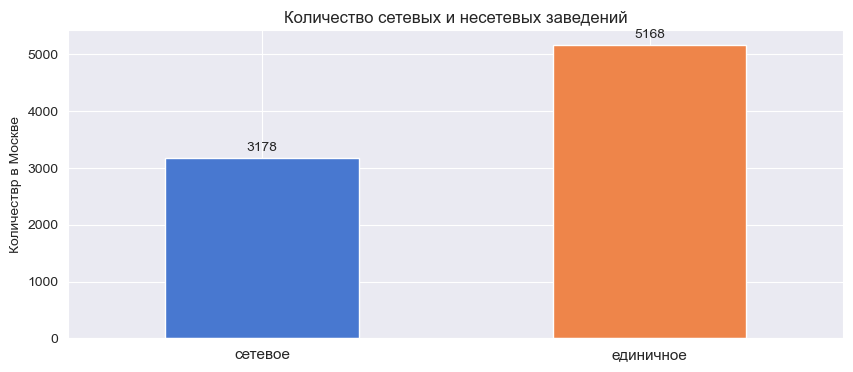

In [63]:
# группируем данные, считаем, сортируем, строим диаграмму
perc_cat = df_cl.groupby('chain')['name'].count().sort_values(ascending=True)
ax = perc_cat.plot(kind='bar', y='category',
                   figsize=(10,4),
                   xlabel='',
                   ylabel='Количествр в Москве',
                   color = sns.color_palette('muted'),
                   title='Количество сетевых и несетевых заведений',)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 7), textcoords='offset points')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=11)
plt.grid()
plt.show()

Несетевых заведений в Москве заметно больше. Это может косвенно свидетельствовать о том, что деловой климат в городе благоприятный для открытия независимой точки общественного питания, а потребление в этом сегменте достаточно активно.

### Какие категории заведений чаще являются сетевыми?

In [66]:
# Выведем количество сетевых заведений по категориям.
df_chain_1 = df_cl[df_cl['chain'] == 'сетевое']
print (df_chain_1['category'].value_counts()) 

category
кафе               774
ресторан           722
кофейня            712
пиццерия           328
быстрое питание    231
бар,паб            168
булочная           156
столовая            87
Name: count, dtype: int64


В Москве примерно равное количество сетевых кафе, ресторанов. Чуть меньше - кофеепн. Эти три категории являются лидерами по данному показаиелю.

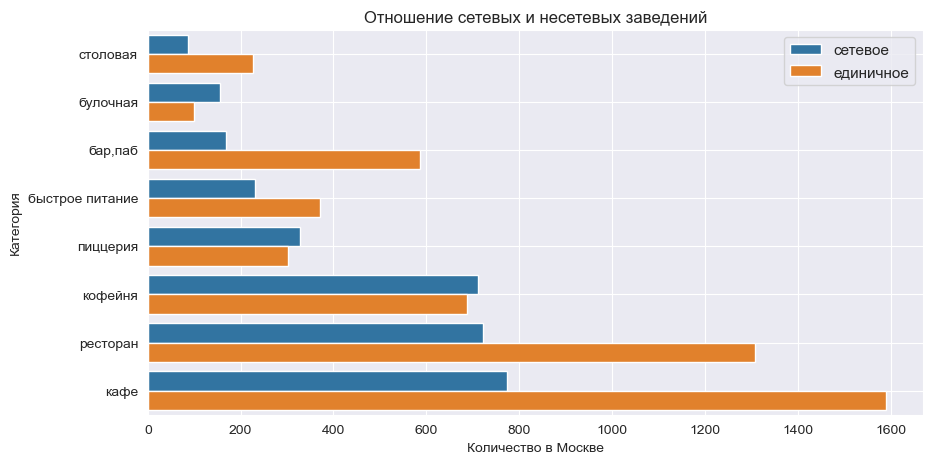

In [68]:
# группируем данные по категории и принадлежности к сетям и считаем имх количество
data_chain = df_cl.groupby(['category', 'chain'], \
                        as_index = False)[['address']].count().sort_values('address',ascending = True)

plt.figure(figsize=(10, 5))
# строим столбчатый график
sns.barplot(x='address', y='category', data=data_chain, hue='chain')

plt.title('Отношение сетевых и несетевых заведений')
plt.xlabel('Количество в Москве')
plt.ylabel('Категория')

plt.legend(loc='upper right', fontsize=11)
plt.grid()
plt.show()

Несетевые заведения явно преобладают в категориях "Бар, паб", "Кафе" и "Ресторан". На наш взгляд это говорит о том, что:
- В этих категориях существует большее разнообразие форматов
- Конкуреннтная среда более гибкая и менее подвержена монополизации.


Последнее утверждение можно проиллюстрировать сравнив положения в этих трёх, "свободных", группах с катеегориями "Булочная" и "Пицерия". В них унификация продукции (выпечка, заготовки и ингридиенты для пицы) и, как следствие, коныентрация производства, даёт существенное ценовое и логистическое преимущество сетям. 

### Группировка данных по названиям заведений. Топ-15 популярных сетей в Москве 
Под популярностью понимается количество заведений сети

In [71]:
# делаем срез - только сетевые
name_15 = df_cl.loc[df_cl['chain']=='сетевое']

#строим сводную таблицу
name_15 = name_15.pivot_table(index=['category','name'], values='address', aggfunc='count').sort_values(by = 'address', ascending=False)
name_15.columns = ['count']
name_15 = name_15.reset_index()
name_15 = name_15.set_index('name')

name_15 = name_15.iloc[:15, :]
display (name_15)

,category,count
name,,
шоколадница,кофейня,116
домино'с пицца,пиццерия,76
додо пицца,пиццерия,74
one price coffee,кофейня,70
яндекс лавка,ресторан,68
cofix,кофейня,65
prime,ресторан,49
кофепорт,кофейня,42
лавка караваевых,кафе,38


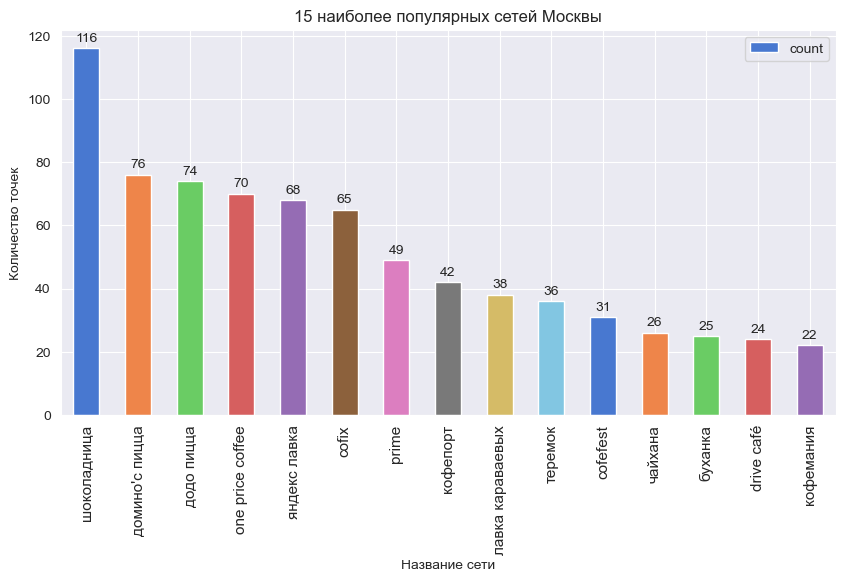

In [72]:
# Строим диаграмму
ax = name_15.plot(kind='bar', y='count',
                   figsize=(10,5),
                   xlabel='Название сети',
                   ylabel='Количество точек',
                   color = sns.color_palette('muted'),
                   grid=True,
                   title='15 наиболее популярных сетей Москвы')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 7), textcoords='offset points')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=11)

plt.show()

Лидером по распространённости в Моске с большим отрывом  является сеть "Шоколадница".
> Говорит ли это о каком-либо преимуществе этой сети по сравнению с другими?\
На наш взгляд - нет. Лидерство, в данном случае, говорит исключительно о количестве вложенных денег.\
Вряд ли оправдано считать распространённость - результатом спроса. На наш взгляд, это яркий пример маркетинговой ситуации, когда именно активное предложение формирует спрос. 

**Посмотрим, к каким категорям относятся лидеры и распределение категорий в данной выборке (Топ-15 сетей)**.

In [75]:
# выводим количество категорий
name_15_cat = name_15['category'].value_counts()
name_15_cat

category
кофейня     6
ресторан    3
кафе        3
пиццерия    2
булочная    1
Name: count, dtype: int64

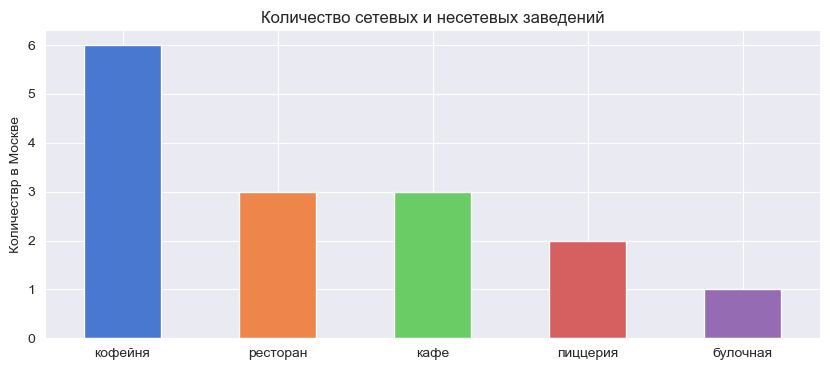

In [76]:
ax = name_15_cat.plot(kind='bar', y='category',
                   figsize=(10,4),
                   grid=True,
                   xlabel='',
                   ylabel='Количествр в Москве',
                   color = sns.color_palette('muted'),
                   title='Количество сетевых и несетевых заведений')
plt.xticks(rotation=0)
plt.show()

Наиболее всего представлены кофейни - 6 сетей. Из оставшихся 4-х категорий 3 - явные представители быстрого питания.
Из трех ресторанных сетей "Теремок" скорее можно назвать "Кафе +", а не ресторан.\
**Таким образом мы видим доминирование демократичных сетей быстрого питания, рассчитанных на широкую публику.**
> Шоколадница, имеющая не очень определённую категорию "кофейня" (что означает, повидимому, недорогое заведение "очень быстрого" питания), на наш взгляд, скорее "кафе".

### Какие административные районы Москвы присутствуют в датасете? 

In [79]:
#Какие административные районы Москвы присутствуют в датасете и общее количество заведений
display (df_cl['district'].value_counts()) 

district
Центральный АО         2242
Северо-Восточный АО     891
Южный АО                890
Северный АО             875
Западный АО             831
Восточный АО            788
Юго-Восточный АО        714
Юго-Западный АО         706
Северо-Западный АО      409
Name: count, dtype: int64

**Посмотрим, как распределены категории заведений общественного питания по административным округам**.

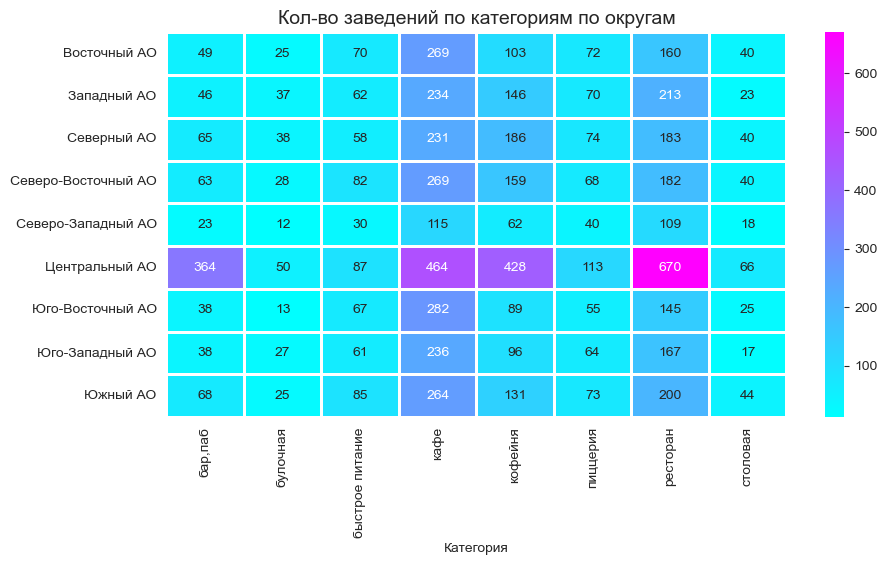

In [81]:
#Строим heatmap
fig, ax = plt.subplots(figsize=(10, 5))
district_category = df_cl.pivot_table(index = 'district', columns =  'category', values = 'name',
                                     dropna = True, aggfunc = 'count')

district_cat = sns.heatmap (district_category, linewidths = 0.8, annot = True, cmap = 'cool', fmt='')
plt.xlabel('Категория')
plt.ylabel('')
plt.title('Кол-во заведений по категориям по округам', fontsize=14)
plt.savefig('график 4.pdf', bbox_inches='tight')
plt.show()

Данная визуализация даёт возможность увидеть распределение по административным округам заведений питания тех или иных категорий.\
Мы видим, что лучше всего в городе предствлены категории Кафе и Ресторан. На третьем месте Кофейни.\
\
Наибольшее количество точек общественного питания в Центральнои административном округе.

 <div class="alert alert-info"> <b> </b> </div>

Следующая диаграмма визуализирует некоторые дополнительные моменты распределения точек питания по округам.

In [85]:
# делаем сводную таблицу
district_category = df_cl.pivot_table(index=['district', 'category'], values='name', aggfunc='count').reset_index()
#display (district_category)


# Делаем таблицу ДЛЯ СОРТИРОВКИ И ПОТОМ ПЕРДАДИМ ЕЁ В ГРАФИК (category_orders)
sorted_district_category = district_category.pivot_table(index='district', values='name', aggfunc='sum').sort_values('name', ascending=False).reset_index()
#display (sorted_district_category)

# строим график
fig = px.bar(district_category,
                   x = 'district',
                   y = 'name',
                   color = 'category',
                   title = 'Административные округа и категории',
                   category_orders = {'district': sorted_district_category['district'].tolist()},
                   width = 900, 
                   height = 600,
                   barmode = 'stack')                   

# Подписи к осям
fig.update_xaxes(title_text = '') 
fig.update_yaxes(title_text = 'Кол-во точек')

#fig.write_html('district_category.html')
#fig.show()
print('')

![district_category](district_category.jpeg)

Как уже отмечалось, наибольшее количество точек питания в ЦАО.\
Но тут мы видим также два момента:
- категории распределены достаточно равномерно по округам - в каждом округе присутствуют все категории, пропорционально общему количеству точек питания в округе.
- Наименьшее количество точек питания в СЗАО, очевидно, из-за особенностей этого округа - на его территории находится излучина реки Москвы, большие площади заняты нежилой застройкой.

### Распределение средних рейтингов по категориям заведений
Как различаются усреднённые рейтинги в разных типах общепита

In [89]:
rating_category = df_cl.pivot_table(index = 'category',  values = 'rating',
                                     aggfunc = 'mean')
display (rating_category)

,rating
category,
"бар,паб",4.390186
булочная,4.267843
быстрое питание,4.049834
кафе,4.123942
кофейня,4.277429
пиццерия,4.300636
ресторан,4.289946
столовая,4.211821


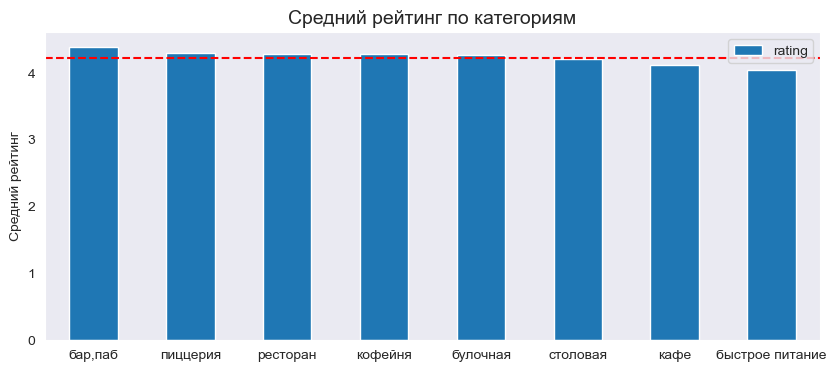

In [90]:
# далаем сводную таблицу и строим диаграмму
rating_category = df_cl.pivot_table(index = 'category',  values = 'rating',
                                     aggfunc = 'mean').sort_values(by = 'rating', ascending=False).plot(kind = 'bar', rot = 0, xlabel = 'Категории', ylabel = 'Средний рейтинг',
         figsize = (10, 4))

# добавляем линию общей медианной цены
rating_category.axhline(df_cl['rating'].mean(), color = "red", linestyle = 'dashed')
plt.xlabel('')
plt.title('Средний рейтинг по категориям', fontsize=14)

plt.show()

**Вопреки ожиданиям рейтинги категорий не имеют существенного разброса.**\
Некоторое проседание заведений "быстрого питания" можно объяснить завышенными ожиданиями потребителей. (Зал с тремя столиками и шаурмой объективно - это не ресторан ни по позиционированию, ни по качеству).


Но, в любом случае, **Быстрое питание отстаёт от Баров всего на треть балла, что вряд ли можно считать существенным.**

### Фоновая картограмма (хороплет) со средним рейтингом заведений каждого района

In [93]:
# Считапем средний рейтинг по округам
rating_df = df_cl.groupby('district', as_index=False)['rating'].agg('mean')
rating_df

,district,rating
0,Восточный АО,4.174239
1,Западный АО,4.179904
2,Северный АО,4.238857
3,Северо-Восточный АО,4.148260
4,Северо-Западный АО,4.208802
5,Центральный АО,4.377520
6,Юго-Восточный АО,4.101120
7,Юго-Западный АО,4.172521
8,Южный АО,4.184157


In [94]:
# импортируем карту и хороплет
from folium import Map, Choropleth

# Открываем и загружаем содержимое GeoJSON-файла с границами округов Москвы в переменную (оба варианта работают)
#with open('modified_admin_level_geomap.geojson', 'r', encoding='utf-8') as f:
    #state_geo = json.load(f)

state_geo = gpd.read_file('modified_admin_level_geomap.geojson')


In [95]:
# Функция для добавления меток на основе центроидов

#import json
#import folium
#import geopandas as gpd
from folium import Choropleth, GeoJson
from folium.features import DivIcon

# Функция для добавления меток на основе центроидов
def add_district_labels(map_object, gdf, label_column):
    for _, row in gdf.iterrows():
        # Получаем центроид области
        centroid = row['geometry'].centroid
        latitude, longitude = centroid.y, centroid.x
        
        # Извлекаем название округа из указанного столбца
        district_name = row[label_column]
        
        # Добавляем метку на карту
        folium.map.Marker(
            [latitude, longitude],
            icon=DivIcon(
                icon_size=(150, 36),
                icon_anchor=(0, 0),
                html=f'<div style="font-size: 12px; color: #e64d00; font-weight: regular">{district_name}</div>',
            )
        ).add_to(map_object)


In [96]:
# moscow_lat - широта центра Москвы, moscow_lng - долгота центра Москвы
moscow_lat, moscow_lng = 55.751244, 37.618423

# создаём карту
map_choropleth_1 = Map(location=[moscow_lat, moscow_lng], zoom_start=10, tiles='Cartodb Positron')

# создаём хороплет и добавляем его на карту
Choropleth(
    geo_data=state_geo,
    data=rating_df,
    columns=['district', 'rating'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.8,
    legend_name='Средний рейтинг заведений по районам').add_to(map_choropleth_1)

# Добавляем стилизацию для легенды с помощью HTML и CSS
legend_html = '''
     <style>
         .legend {font-size: 14px;
             #font-weight: bold;
             color: black;}
     </style>
     <div class="legend">Средний рейтинг заведений по районам</div>
     '''
map_choropleth_1.get_root().html.add_child(folium.Element(legend_html))

# Вызов функции для добавления меток
add_district_labels(map_choropleth_1, state_geo, label_column='ref')
print('')

#map_choropleth_1.save('choropleth_1.html')
#map_choropleth_1

![choropleth_1](choropleth_1.jpeg)

В центре города сосредоточены заведения с наибольшим рейтингом - престижность места диктует свои требования к качеству.


Наименьший рейтинг у точек питания в ЮВАО. Этот округ считается наиболее демократичным - здесь более низкие цены на недвижимость, много промышленных предприятий. Видимо, это отражается на подходе владельцев и управляющих точками питания к качеству.

Учитывая, что все категории предствлены в административных округах равномерно и пропорционально (о чём говорилось выше), то более низкие показатели рейтинга в этом округе имеют все категории заведений общественного питания.

### Все заведения датасета на карте отображённые с помощью кластеров


In [100]:
# импортируем карту маркер и кластер
from folium import Map, Marker
from folium.plugins import MarkerCluster

# координаты Москвы
moscow_lat, moscow_lng = 55.751244, 37.618423

# создаём карту
m = Map(location=[moscow_lat, moscow_lng], zoom_start=10, tiles="Cartodb Positron")
# создаём пустой кластер, добавляем его на карту
marker_cluster = MarkerCluster().add_to(m)

# пишем функцию
def create_clusters(row):
    Marker(
        [row['lat'], row['lng']],
        popup=f"{row['name']} {row['category']}",
    ).add_to(marker_cluster)

# применяем функцию create_clusters() к каждой строке датафрейма
df_cl.apply(create_clusters, axis=1)

# выводим карту

#m.save('map_1.html')
#m
print('')

![map_1](map_1.jpeg)

Данная визуализайия позволяет детально рассмотреть интересующие районы, исследовать взаиморасположение точек питания. Это может быть важным при выборе конкретного места для открытия нового заведения.

### Топ-15 улиц по количеству заведений
График распределения количества заведений и их категорий по этим улицам

In [104]:
# делаем сводную таблицу, считаем кол-во точек питания сортируем и берём 15 первых 
df_1 = df_cl.pivot_table(index='street', values='address', aggfunc='count').reset_index().sort_values('address', ascending=False).head(15)

# добавляем category к 15-и улицам  
df_2 = df_1.merge(df_cl, on='street', how='left')

# делаем финальную сводную таблицу
top_streets = df_2.pivot_table(index=['street', 'category'], values='name', aggfunc='count').reset_index()

# Делаем таблицу ДЛЯ СОРТИРОВКИ И ПОТОМ ПЕРДАДИМ ЕЁ В ГРАФИК (category_orders)
sorted_top_streets = top_streets.pivot_table(index='street', values='name', aggfunc='sum').sort_values('name', ascending=False).reset_index()

#display (sorted_top_streets)
# строим график
fig = px.bar(top_streets,
                   x='street',
                   y='name',
                   color='category',
                   title='Топ-15 улиц Москвы по количеству точек питания',
                   category_orders={'street': sorted_top_streets['street'].tolist()},
                   width = 900, 
                   height = 600,
                   barmode = 'stack')
                     
# Подписи к осям
fig.update_xaxes(title_text = '') 
fig.update_yaxes(title_text = 'Кол-во точек')

#fig.write_html('street_eateries.html')
#fig.show()
print('')

![street_eateries](street_eateries.jpeg)

Как и предыдущая визуализация, эта гистограмма может помочь лучше понять состояние рынка общепита на некоторых улицах города.

> Но на наш взгляд, это сугубо вспомогательная информация.\
По большей части здесь представлены радиальные магистрали (и даже МКАД), которые из-за своей протяженности очень неравномерны по характеру городской среды. Многие из них начинаяся в центре города и на своём протяжении проходят и промзоны, и парковые комплексы, и крупные транспортные узлы, и районы жилой застройки разных времён.\
**Невозможно сравнивать, к примеру, начало Лениградского проспекта и его окончание. И тем более делать в таких условиях какие-либо усреднения и обобщения вроде подсчёта общего количества точек питания.** 


>К примеру, Варшавское шоссе - это трасса в 22 км с 14-ю транспортными пересадочными узлами.\
Или проспект Мира (лидер по кол-ву точек питания), который имеет 9 километров - начинается в историческом центре города, проходет через район ВДНХ - традиционное место отдыха - и заканчивается в "спальных" районах.\
**Тотальный подсчёт точек питания на таких магистралях не имеет практического маркетингового смысла.**

### Улицы, на которых находится только один объект общепита

In [108]:
# выделяем улицы с 1 точкой питания
df_street_one = df_cl[~df_cl['street'].duplicated()]
df_street_one = df_street_one.reset_index(drop=True)
#df_street_one

In [109]:
street_count_one =  df_street_one.groupby('district', as_index=False)['street'].agg('count')\
                     .sort_values('street',ascending = False)
street_count_one

,district,street
5,Центральный АО,448
0,Восточный АО,163
3,Северо-Восточный АО,159
2,Северный АО,148
8,Южный АО,142
6,Юго-Восточный АО,124
1,Западный АО,117
4,Северо-Западный АО,74
7,Юго-Западный АО,73


In [110]:
# geoJSON-файл с границами округов Москвы ЗАГРУЖЕН РАНЕЕ
# moscow_lat - широта центра Москвы, moscow_lng - долгота центра Москвы
moscow_lat, moscow_lng = 55.751244, 37.618423

# создаём карту
map_choropleth_2 = Map(location=[moscow_lat, moscow_lng], zoom_start=10, tiles='Cartodb Positron')

# создаём хороплет и добавляем его на карту
Choropleth(
    geo_data = state_geo,
    data = street_count_one,
    columns = ['district', 'street'],
    key_on='feature.properties.name',
    fill_color='RdPu',
    fill_opacity = 0.8,
    legend_name = 'Количество улиц с одной точкой питания',
   ).add_to(map_choropleth_2)

# Добавляем стилизацию для легенды с помощью HTML и CSS
legend_html = '''
     <style>
         .legend {font-size: 14px;
                  #font-weight: bold;
                  color: black;}
     </style>
     <div class="legend">Количество улиц с одной точкой питания</div>
     '''
map_choropleth_2.get_root().html.add_child(folium.Element(legend_html))

# Вызов функции для добавления меток
add_district_labels(map_choropleth_2, state_geo, label_column='ref')
print('')

#map_choropleth_2.save('choropleth_2.html')
#map_choropleth_2

![choropleth_2](choropleth_2.jpeg)

Концентрация улиц с одним единственным заведением в центре города - следствие наличия там большого количества коротких улиц и переулков. Это особенности исторической застройки.

Наличие таких улиц в других округах также объясняется этим фактором. Границы современных административных округов не отражают истории формирования города. Те части современных округов, которые прилегают к Центральному, захватывают также районы, затраивавшиеся в 17-18 веках. Благодаря этому в них также есть короткие улицы и переулки.

Что можно сказать о заведениях, расположенных на таких улицах? Ничего, что было бы обусловлено фактом такой "единичности".
Ниже приведена статискика представленности категорий на таких улицах.


In [113]:
print (df_street_one['category'].value_counts())


category
кафе               433
ресторан           354
кофейня            232
бар,паб            158
пиццерия            97
столовая            73
быстрое питание     68
булочная            33
Name: count, dtype: int64


Мы видим пропорциональную представленность всех категорий точек питания. Из чего делаем вывод - единичность конкретного заведения на улице определяется не особенностью заведения, а исключительно малой длиной улицы (переулка), а категория заведения не фактом её единственности на улице, а комплексом других факторов.

### Средний чек


Числа из столбца 'middle_avg_bill' показывают примерную стоимость заказа в рублях, которая чаще всего выражена диапазоном.

Принимаем медианное значение среднего чека в качестве ценового индикатора административного округа.

In [118]:
#Считаем медиану среднего чека для каждого района.
middle_avg_bill_df = df_cl.groupby('district', as_index=False)['middle_avg_bill'].agg('median')\
                     .sort_values('middle_avg_bill',ascending = False)
middle_avg_bill_df

,district,middle_avg_bill
1,Западный АО,1000.0
5,Центральный АО,1000.0
4,Северо-Западный АО,700.0
2,Северный АО,650.0
7,Юго-Западный АО,600.0
0,Восточный АО,550.0
3,Северо-Восточный АО,500.0
8,Южный АО,500.0
6,Юго-Восточный АО,450.0


In [119]:
# geoJSON-файл с границами округов Москвы ЗАГРУЖЕН РАНЕЕ

# Строим фоновую картограмму (хороплет) с полученными значениями для каждого района
# moscow_lat - широта центра Москвы, moscow_lng - долгота центра Москвы
moscow_lat, moscow_lng = 55.751244, 37.618423

map_choropleth_3 = Map(location=[moscow_lat, moscow_lng], zoom_start=10, tiles='Cartodb Positron')

# создаём хороплет и добавляем его на карту
Choropleth(
    geo_data = state_geo,
    data = middle_avg_bill_df,
    columns = ['district', 'middle_avg_bill'],
     key_on='feature.properties.name',
    fill_color='BuPu',
    fill_opacity = 0.8,
    legend_name = 'Средний чек заведений по районам',
   ).add_to(map_choropleth_3)

# Добавляем стилизацию для легенды с помощью HTML и CSS
legend_html = '''
     <style>
         .legend {font-size: 14px;
                  #font-weight: bold;
                  color: black;}
     </style>
     <div class="legend">Средний чек заведений по районам</div>
     '''
map_choropleth_3.get_root().html.add_child(folium.Element(legend_html))

# Вызов функции для добавления меток
add_district_labels(map_choropleth_3, state_geo, label_column='ref')

#map_choropleth_3.save('choropleth_3.html')
#map_choropleth_3

![choropleth_3](choropleth_3.jpeg)

О стоимости среднего чека можно сказать следующее:\
- ЮВАО - округ, наиболее демократичный по ценам на недвижимость, в том числе арендную. Промышленный округ. Имеет самый низкий средний чек.
- ЦАО и ЗАО - лидеры по ценам. Первый благодаря географическому положению (центр города), второй - потому, что в этом направлении традиционно расположены престижные районы с высокой стоимости недвижимости, лучшей экологией и инфраструктурой.
- СВАО и ЮАО - спальные районы разных лет застройки непрестижным типовым жильём.

 <div class="alert alert-info"> <b> </b> </div>

### Влияние удалённости от центра города на цены в заведениях

Формула для вычисления расстояния между двумя точками использует данные широты и долготы шкала расстояний на графике также **выражается в градусах**.
>**Это  расстояние не в километрах**,\
но так как этот показатель нужен нам для иллюстрации зависимости цены от расстояния, то расстояние выраженное таким образом вполне адекватно для данной цели.

(Тем самым мы избегаем загрузки специализированных библиотек)

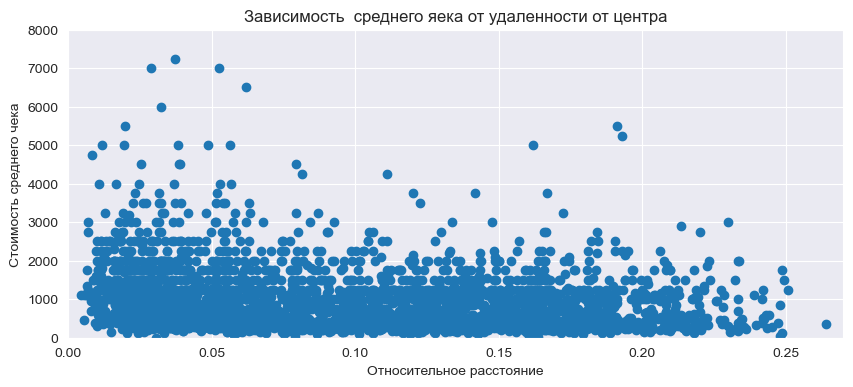

In [125]:
# Строим график зависимости цен от удаленности точек от центра города
# задаём параметры графика
plt.figure(figsize=(10, 4))
sns.set_style('dark')
plt.xlim(0, 0.27)
plt.ylim(0, 8000)

# Строим график
plt.scatter(df_cl['distance'], df_cl['middle_avg_bill'])

plt.xlabel('Относительное расстояние')
plt.ylabel('Стоимость среднего чека')
plt.title('Зависимость  среднего яека от удаленности от центра')
plt.grid()
plt.show()

**Зависимость величины среднего чека от расстояния до центра города есть, но она выражается НЕ в том, что снижается средний чек как таковой, а в ценовом составе заведений.**

Чем  ближе к центру, тем больше дорогих заведений, которые работают наряду с более демократичными.
    

Практичеси ровное распределение дешёвых и средне-ценовых заведений (до 2000 руб.) по всей длине шкалы расстояния,\
и то, что более дорогие заведения присутствуют также и вне центра города, говорит о том, что **средний чек в Москве мало чувствителен к расстоянию до центра.**

 <div class="alert alert-info"> <b> </b> </div>

## Общий вывод из анализав данных

### Характеристика заведений питания

1.\
Большая часть заведений питания в Москве относятся к категориям **"Кафе" и "Ресторан"**.
>В  сознании среднестатистического потребителя они имеют достаточно понятную дифференциацию: кафе - демократичнее и дешевле, ресторан пафоснее и дороже.\
На практике далеко не всегда так, но при выборе категории для бизнеса эту особенность нужно учитывать.\
Третье место по распространённости занимает категория "Кофейня". Это неопределённая категория, скорее маркетингового характера.

2.\
В среднем **ресторан имеет большее количество мест**, чем кафе\
Можно сделать вывод, что зал среднего ресторана больше зала среднего кафе. Следователоьно и общая занимаемая площадь - больше, что делает запуск этого формата более капиталоёмким уже на стадии подбора помещения.

3.\
**Несетевых заведений в Москве заметно больше**.
Это свидетельствует о том, что **деловой климат в городе благоприятный для открытия независимой точки, а потребление в этом сегменте достаточно активно**.

4.\
**Несетевые заведения явно преобладают в категориях "Бар,паб", "Кафе" и "Ресторан"**.\
Это свидетельство того, что в этих категориях существует большее разнообразие форматов, онкуреннтная среда более гибкая и менее подвержена монополизации.


5.\
Сеть **"Шоколадница" - лидер по распространённости** в Москвые с большим отрывом от других.
>Вряд ли оправдано считать распространённость - результатом спроса. На наш взгляд, это яркий пример маркетинговой ситуации, когда именно активное предложение формирует спрос.

6.\
Более всего представлены сети кофеин - 6 сетей. Из оставшихся 4-х категорий 3 - явные представители быстрого питания.\
Видно  **доминирование недорогих сетей быстрого питания, рассчитанных на широкую публику**.

7.\
**Круглосуточно и ежедневно** работает только 8,7 % заведений г. Москвы (730 из 8405). Сложно сказать - много это или мало, но фактв том, что такой режим не является распространённым в городе.

### Распределение по территории города и рейтинги

1.\
**Наибольшее количество точек общественного питания в Центральнои административном округе**, что вполне лдогично.


**Наименьшее кол-во точек питания в СЗАО**, очевидно, из-за особенностей этого округа - на его территории находится излучина реки Москвы, большие площади заняты нежилой застройкой.

2.\
**По округам категории заведений распределены достаточно равномерно**  - в каждом округе присутствуют все категории, пропорционально общему количеству точек питания.

3.\
Вопреки ожиданиям **реётинги категорий не имеют существенного разброса**.
>Некоторое проседание заведений "быстрого питания" можно объяснить завышенными ожиданиями потребителей. (Зал с тремя столиками и 
шаурмой объективно - это не ресторан ни по позиционированию, ни по качеству).

Но, в любом случае, Быстрое питание отстаёт от баров всего на треть балла, что вряд ли можно считать существенным.

4.\
**Заведения с наибольшим рейтингом сосредоточены в центре города** - престижность места диктует свои требования к качеству.

**Наименьший рейтинг у точек питания в ЮВАО**. Этот округ считается наиболее демократичным - здесь более низкие цены на недвижимость, много промышленных предприятий. Видимо, это отражается на подходе владельцев и управляющих точками питания к качеству.

5.\
Что касается **распределения заведений по улицам**, но мы считаем такой анализ **не релевантным для Москвы**.


Жители города в меньшей степени соотносят свою жизнь с улицами. И жители и бизнес B2C опираются на **районирование**, привязанное к:
- станциям метро или электричек,
- пересадочным узлам,
- зонам отдыха и паркам,
- крупным торговым центрам.

**При принятии решения об открытии бизнеса** нужно ориентироваться не на характеристику  какой-либо улицы, а на характеристики района в целом - на структуру территории, транспортные и пассажирские потоки. А в жилых массивах - на социально-демографические зарактеристики населения.


В Москве много как сверхкоротких улиц и переулков, так и протяженных магистралей. И в том и в другом случае на первое место выступает характеристика района, на не улицы, как таковой.

> К примеру, Варшавское шоссе - это трасса в 22 км с 14-ю транспортными пересадочными узлами.\
А проспект Мира (лидер по кол-ву точек питания) имеет 9 километров длины - начинается в историческом центре города, проходет через район ВДНХ - традиционное место отдыха - и заканчивается в "спальных" районах.\
**Рассматривать такие магистрали как единую маркетинговую зону не имеет практического смысла**.


### Стоимость среднего чека

1.\
**Центральный и Западный округа** - лидеры по ценам.\
Первый благодаря географическому положению (центр города),\
второй - потому, что в этом направлении традиционно расположены престижные районы с высокой стоимост. недвижимости, лучшей экологией и инфраструктурой.


**Северо-восточный и Южный округа** - аккумуляруют спальные районы разных олет застройки с непрестижным типовым жильём.
**Юго-восточный** - округ, наиболее демократичный по ценам на недвижимость, в том числе арендную. Промышленный округ. Имеет самый низкий средний чек.

2.\
**Зависимость величины среднего чека от расстояния до центра города есть**, но она выражается НЕ в том, что с удалением от центра снижается средний чек как таковой, а в **ценовом составе заведений**.

Чем ближе к центру, тем больше дорогих заведений, которые работают наряду с более демократичными.

**Средний чек в Москве мало чувствителен к расстоянию от центра**.\
Наблюдается  практически ровное распределение дешёвых и среднеценовых заведений (до 1000 руб.) по всей длине шкалы расстояния,
а также присутствие более дорогих заведений вне центра города. 


 <div class="alert alert-info"> <b> </b> </div>

## Детализируем исследование: открытие кофейни

Основателям фонда «Shut Up and Take My Money» хотят открыть такую же крутую и доступную, как «Central Perk» (сериал «Друзья»), кофейню в Москве.\
Заказчики не боятся конкуренции в этой сфере.\
Надо определить, реально ли осуществить такой план.

Вопросы:
- Сколько всего кофеен в датасете?
- В каких районах их больше всего, каковы особенности их расположения?
- Есть ли круглосуточные кофейни?
- Какие у кофеен рейтинги? Как они распределяются по районам?
- На какую стоимость чашки капучино стоит ориентироваться при открытии и почему?
- Какие рекомендацию для открытия нового заведения?


### Сколько всего кофеен в датасете?

In [139]:
# Отфильтровываем кофейни и смотрим объём таблицы
df_coff = df_cl[df_cl['category'] == 'кофейня']
df_coff = df_coff.reset_index(drop=True)
#display (df_coff)
df_coff.shape

(1400, 17)

В датасете 1400 кофеен.

### В каких районах кофеен больше всего, каковы особенности их расположения?

Для поиска ответа применим 2 метода.
- Распределение по административным округам
- Отобразим все кофейни на карте с помощью кластеров

In [143]:
#Считаем количество для каждого района.
coff_district = df_coff.groupby('district', as_index=False)['name'].agg('count')\
                     .sort_values('name',ascending = False)
coff_district

,district,name
5,Центральный АО,428
2,Северный АО,186
3,Северо-Восточный АО,159
1,Западный АО,146
8,Южный АО,131
0,Восточный АО,103
7,Юго-Западный АО,96
6,Юго-Восточный АО,89
4,Северо-Западный АО,62


In [144]:
# geoJSON-файл с границами округов Москвы ЗАГРУЖЕН РАНЕЕ

# moscow_lat - широта центра Москвы, moscow_lng - долгота центра Москвы
moscow_lat, moscow_lng = 55.751244, 37.618423

# создаём карту
map_choropleth_4 = Map(location=[moscow_lat, moscow_lng], zoom_start=10, tiles='Cartodb Positron')

# создаём хороплет и добавляем его на карту
Choropleth(
    geo_data = state_geo,
    data = coff_district,
    columns = ['district', 'name'],
     key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity = 0.8,
    legend_name = 'Количество кофеен по районам',
   ).add_to(map_choropleth_4)

# Добавляем стилизацию для легенды с помощью HTML и CSS
legend_html = '''
     <style>
         .legend {font-size: 14px;
                  #font-weight: bold;
                  color: black;}
     </style>
     <div class="legend">Количество кофеен по районам</div>
     '''
map_choropleth_4.get_root().html.add_child(folium.Element(legend_html))

# Вызов функции для добавления меток
add_district_labels(map_choropleth_4, state_geo, label_column='ref')  # Замените 'ref' на нужное поле

#map_choropleth_4.save('map_choropleth_4.html')
#map_choropleth_4

![choropleth_4](choropleth_4.jpeg)

По количеству кофеен с большим отрывом лидирует Центральный округ.\
Меньше всего в Северо-зарадном. Но в этом округе также меньше и общее количество заведений питания из-за особенностей его географии.

In [147]:
# импортируем карту маркер и кластер
from folium import Map, Marker
from folium.plugins import MarkerCluster

# координаты Москвы
moscow_lat, moscow_lng = 55.751244, 37.618423

# создаём карту
m_coff = Map(location=[moscow_lat, moscow_lng], zoom_start=10, tiles="Cartodb Positron")
# создаём пустой кластер, добавляем его на карту
marker_cluster = MarkerCluster().add_to(m_coff)

# пишем функцию
def create_clusters(row):
    Marker(
        [row['lat'], row['lng']],
        popup=f"{row['name']} {row['category']}",
    ).add_to(marker_cluster)

# применяем функцию create_clusters() к каждой строке датафрейма
df_coff.apply(create_clusters, axis=1)

# выводим карту

#m_coff.save('m_coff.html')
#m_coff
print('')

![map_coffe](map_coffe.jpeg)

На этой карте мы можем посмотреть взаиморасположение кофеен в конкретных интересующих нас районах и зонах города. Это полезно при выборе конкретного места для открытия новой точки.

### Есть ли круглосуточные кофейни?

**Сравним режимы работ кофеен и заведений питания всех категорий в городе**.

In [152]:
#Считаем количество круглосуточных во всех категориях для каждого режима работы.
df_all = df_cl[df_cl['category'] != 'кофейня']
all_24_7 = df_all.pivot_table(index = 'is_24_7',  values = 'name',
                                     aggfunc = 'count').sort_values('name',ascending = False)
all_24_7.columns = [ 'кол-во']
display (all_24_7)

,кол-во
is_24_7,
24/7 - НЕТ,6279
24/7 - ДА,667


In [153]:
#Считаем количество круглосуточных кофеен для каждого режима работы.
coff_24_7 = df_coff.pivot_table(index = 'is_24_7',  values = 'name',
                                     aggfunc = 'count').sort_values('name',ascending = False)
coff_24_7.columns = [ 'кол-во']
display (coff_24_7)

,кол-во
is_24_7,
24/7 - НЕТ,1341
24/7 - ДА,59


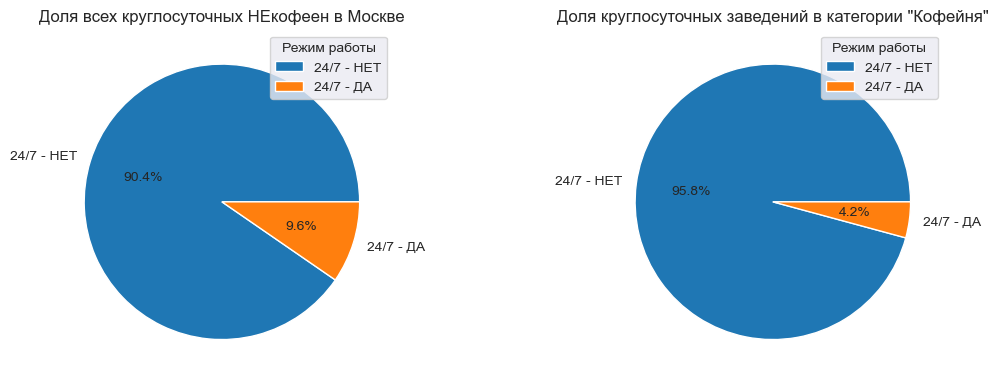

In [154]:
# Фигура и оси для подграфиков
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Диаграмма 'Доля всех круглосуточных заведений в Москве'
all_24_7.plot(y='кол-во', kind='pie', autopct='%1.1f%%', ax=axs[0])
axs[0].set_xlabel('')
axs[0].set_ylabel('')
axs[0].set_title('Доля всех круглосуточных НЕкофеен в Москве')
axs[0].legend(title='Режим работы')

# Диаграмма 'Доля круглосуточных заведений в категории "Кофейня"'
coff_24_7.plot(y='кол-во', kind='pie', autopct='%1.1f%%', ax=axs[1])
axs[1].set_xlabel('')
axs[1].set_ylabel('')
axs[1].set_title('Доля круглосуточных заведений в категории "Кофейня"')
axs[1].legend(title='Режим работы')

# Автоматическая коррекция размещения подграфиков для лучшей читаемости
plt.tight_layout()
plt.subplots_adjust(wspace=0.6)

plt.show()

Доля круглосуточных кофеен невелика - 4,2% от общего количества. Это более, чем в два раза меньше, чем доля круглосуточных заведений среди других категорий.

### Количество мест в категории Кофейня

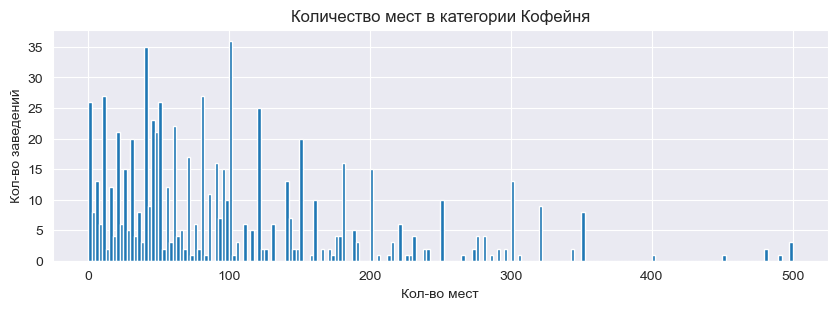

In [157]:
df_coff['seats'].hist(bins=200,figsize=(10, 3))
plt.title('Количество мест в категории Кофейня')
plt.xlabel('Кол-во мест')
plt.ylabel('Кол-во заведений')
plt.show()

Мы видим, что большая часть кофеен имеет до 100 мест.\
Посмотрим ситуацию по районам.

In [159]:
seats_coff = df_coff.groupby('district', as_index=False)['seats'].agg('median').sort_values('seats',ascending = False)
seats_coff

,district,seats
1,Западный АО,96.0
4,Северо-Западный АО,87.5
5,Центральный АО,86.0
8,Южный АО,80.0
3,Северо-Восточный АО,75.0
7,Юго-Западный АО,64.5
2,Северный АО,58.0
0,Восточный АО,55.0
6,Юго-Восточный АО,50.0


Очень показательная таблица, позволяющая оценить предполагаемую проходимость точки при полной загрузке зала в зависимости от района.\
Эти данные будут использованы в рекомендациях.

### Какие у кофеен рейтинги? Как они распределяются по районам?

In [162]:
# Считапем средний рейтинг кофеен по округам
rating_coff = df_coff.groupby('district', as_index=False)['rating'].agg('mean').sort_values('rating',ascending = False)
rating_coff

,district,rating
5,Центральный АО,4.336449
4,Северо-Западный АО,4.325806
2,Северный АО,4.291935
0,Восточный АО,4.285437
7,Юго-Западный АО,4.283333
8,Южный АО,4.232824
6,Юго-Восточный АО,4.225843
3,Северо-Восточный АО,4.216981
1,Западный АО,4.193151


In [163]:
# geoJSON-файл с границами округов Москвы ЗАГРУЖЕН РАНЕЕ

# moscow_lat - широта центра Москвы, moscow_lng - долгота центра Москвы
moscow_lat, moscow_lng = 55.751244, 37.618423

# создаём карту
map_choropleth_5 = Map(location=[moscow_lat, moscow_lng], zoom_start=10, tiles='Cartodb Positron')

# создаём хороплет и добавляем его на карту
Choropleth(
    geo_data=state_geo,
    data=rating_coff,
    columns=['district', 'rating'],
     key_on='feature.properties.name',
    fill_color='YlGnBu',
    fill_opacity=0.8,
    legend_name='Средний рейтинг кофеен по районам',
   ).add_to(map_choropleth_5)

# Добавляем стилизацию для легенды с помощью HTML и CSS
legend_html = '''
     <style>
         .legend {font-size: 14px;
                  #font-weight: bold;
                  color: black;}
     </style>
     <div class="legend">Средний рейтинг кофеен по районам</div>
     '''
map_choropleth_5.get_root().html.add_child(folium.Element(legend_html))


# Вызов функции для добавления меток
add_district_labels(map_choropleth_5, state_geo, label_column='ref')  # Замените 'ref' на нужное поле


#map_choropleth_5.save('choropleth_5.html')
#map_choropleth_5

![choropleth_5](choropleth_5.jpeg)

Рейтинги кофеен достаточно **высокие и мало различаются по административным округам**. Разброс всего 0.15 балла.\
В любом случае, в ЦАО более высокий средний рейтинг.

### На какую стоимость чашки капучино стоит ориентироваться при открытии и почему?

Так как мы проводим исследование внутри одной категории, то логично допустить, что заведения внутри категории имеют определённые сходства в организации бизнеса, формате и позиционировании.


Заказчики хотят открыть именно Кофейню, ориентируясь пари этом на массового потребителя.\
В этом случае **целесообразно остаться в ценовых пределах данной категории, не выходя за рамки ожидаемого посетителями уровня цен**.

Посмотрим медианное значение стоимости чашки капучино в категории Кофейни с разюивкой по админгистративным округам.

In [168]:
# Считапем медианное значение стоимости чашки капучино по округам
middle_coffee_cup_coff = df_coff.pivot_table(index = 'district',  values = 'middle_coffee_cup',
                                     aggfunc = 'median').sort_values('middle_coffee_cup',ascending = False)
middle_coffee_cup_coff

,middle_coffee_cup
district,
Юго-Западный АО,198.0
Центральный АО,190.0
Западный АО,187.0
Северо-Западный АО,165.0
Северо-Восточный АО,162.5
Северный АО,159.0
Южный АО,150.0
Юго-Восточный АО,147.5
Восточный АО,135.0


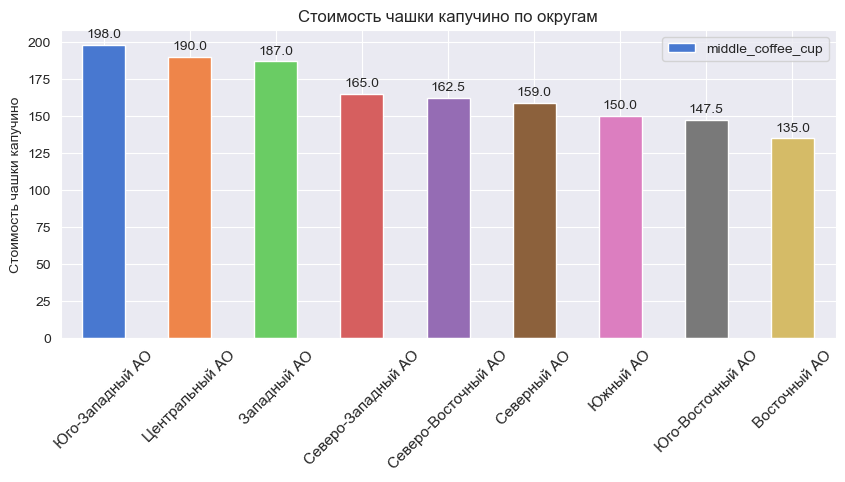

In [169]:
#name_category = df_cl.groupby('category')['name'].count().sort_values(ascending=False)
ax = middle_coffee_cup_coff.plot(kind='bar', y='middle_coffee_cup',
                   figsize=(10,4),
                   xlabel='',
                   ylabel='Стоимость чашки капучино',
                   color = sns.color_palette('muted'),
                   title='Стоимость чашки капучино по округам')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 7), textcoords='offset points')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=11)
plt.grid()

plt.show()

Наиболее высокая цена в Юго-западном и в Центральном округах.  Наименьшая - в промышленныз округах - Восточном и Юго-восточном.

 <div class="alert alert-info"> <b> </b> </div>

### Рекомендацию для открытия нового заведения

#### Общие положения


Изначально желание заказчиков - открыть кафейню - "крутую" и "доступную".

**Доступность**. Содержание этого понятия, как мы можем предположить, для заказчиков заключается в том, что их кафейню могут посещать как можно более широкии слои населения. Но в идеале этот параметр не достижим, поэтому требует определений.
Постараемся ограничить это понятие оптимальными на наш взгляд рамками.\
Разделим это понятие на несколько частей:
- Доступночть физическая
- Доступность экономическая
- Доступность социальная

>**Физическая доступность** обеспечивается оптимальным расположением обеспечивающим постоянный приток достаточного для фуекционирования заведения количества посетителей. Здесть стоит обратить внимание на наличие парковки, близости станций метро или крупных транспортных узлов в пешей доступности, лёгкость нахождения при первом посещении.

>**Экономическая доступность**. Характеризуется ценовым уровнем заведени, который, для реализации желания максимальной доступности не долен быть больше, чем в аналогичных заведениях в пределах выбранного района. А при запуске проекта, даже ниже.

>**Социальная доступность**. Наиболее сложная характеристика. Здесь необходимо ответить на ряд вопросов:\
а)Будет ли обслуживание доступно для людей с ограниченными возможностями?\
б)Будут ли созданы условия для посетителей с детьми?\
в)Будут ли в меню блюда предназначенные для различных пищевых предпочтений?\
г)Будет ли стиль обслуживания, дизайн помещения приемлем для людей с различными эстетическими предпочтениями или будет иметь ярко выраженый стилевой характер?


**Крутизна**. Очень расплывчатое определени. Так как пообщаться на эту тему с заказчиками мы не можем, то выдвинем свои соображения на этот счёт.

Определим это так - **"Место, в которое людям хочется возвращаться"**.
>То есть, по сути мы вводим понятие атмосферы, которое, в принципе, уже можно будет конкретизировать при формулировании ТЗ для специалистов (архитекторов, дизайнеров интерьеров, аудио-дизайнеров и так далее.



Попробуем конкретизировать эти пожелания.

#### Физическая доступность. Место.

На наш взгляд, для поставленной задачи (учитывая, что заказчики не боятся конкуренции), лучшим местом для открытия заведения является центр города.\
Именно здесь обеспечивается достиупность заведения для неограниченного количества посетиелей. Большим преимуществом центра является то, что социальный состав публики очень разнороден, что открывает возможности для экспериментов с позиционированием как на этапе разработки проекта, так и в процессе его функционирования.
>Владельцы могут выбрать себе тот срез публики, который наиболее соответствует их представлению о "крутизне" их кофейни. **Варьируя режим работы, меню, цены, элементы декора, можно добиться необходимого позиционирования без потери потока посетителей**.\
В отличие, например, от спальных районов, транспортных узлов или например, парков.  (Различия этих локаций мы рассматривать не будем, так как это отдельная, обширная, тема).

Центр города имеет только один недостаток - практическое отсутствие парковок. Но так как это свойство практически всех мегаполисов, то этим фактором можно пожертвовать. Пешая же доступность от многочисленных станций метро в центре Москвы великолепная.

#### Количество  мест

Большинство кофеин в ЦАО Москвы имеют  86 мест (медиана). На эту цифру и стоит ориентироваться как на возможный максимум.\
86 мест - это примерно 20 столов по 4 места. Возможно ли в предполагаемой бизнес-модели размещение и обслуживание 20 столов - тема для отдельной проработки. 

#### Ценовая категория

Что касается ценовой категории, то мы можем опираться на медианное значение стоимости чашки капучино в ЦАО.\
**Это 190 рублей**.\
При открытии целесообразно устаносить цены на 10% ниже, и дальше регулировать цены в зависимости от проходимости (фактической и предельно возможной).

#### Режим работы

Подавляющее большинство заведений в Москве не работают в режиме 24/7. Этот режим исплользуют только 9.6 % точек
В категории Кофейня это показатель ещё ниже - 4.2%.

Если бы этот режим был экономически оправдан, то его доля была бы значательно выше.\
Мы не видим смысла  вводить режим 24/7.\
Непосредственно же режим работы нужно будет определять одновременно с разработкой позиционировани новой кофейни.

## В качестве заключения

Проведённое исследование показало, что благодаря достаточно благоприятному деловому климату, о чём говорит большое количество несетевых заведений, и устойчивому спросу на точки общественного питания различных категорий, открытие кофейни вполне может привести к успеху.

**Важно как можно более чётко проработать позиционирование**, части элементов которого мы коснулись в пункие 5.7.1  "Общие положения". 